In [ ]:
!tar -zxvf /content/drive/MyDrive/FinalSemesterProject/Northwestern_Hand_Gesture_flow.tar.gz -C /content/drive/MyDrive/FinalSemesterProject/datasets/

content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/
content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/01/
content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/01/01_Index_01_real.jpg
content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/01/01_Index_01_optical.jpg
content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/01/01_Hand_01_real.jpg
content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/01/01_Hand_01_optical.jpg
content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/01/01_Hold_01_real.jpg
content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/01/01_Hold_01_optical.jpg
content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/01/01_Fist_01_real.jpg
content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/01/01_Fist_01_optical.jpg
content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/01/01_SideIndex_01_real.jpg

In [ ]:
!mv /content/drive/MyDrive/FinalSemesterProject/datasets/content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/ /content/drive/MyDrive/FinalSemesterProject/datasets

mv: cannot stat '/content/drive/MyDrive/FinalSemesterProject/datasets/content/drive/MyDrive/SemesterProject/datasets/Northwestern_Generated/': No such file or directory


In [ ]:
!mv --help

Usage: mv [OPTION]... [-T] SOURCE DEST
  or:  mv [OPTION]... SOURCE... DIRECTORY
  or:  mv [OPTION]... -t DIRECTORY SOURCE...
Rename SOURCE to DEST, or move SOURCE(s) to DIRECTORY.

Mandatory arguments to long options are mandatory for short options too.
      --backup[=CONTROL]       make a backup of each existing destination file
  -b                           like --backup but does not accept an argument
  -f, --force                  do not prompt before overwriting
  -i, --interactive            prompt before overwrite
  -n, --no-clobber             do not overwrite an existing file
If you specify more than one of -i, -f, -n, only the final one takes effect.
      --strip-trailing-slashes  remove any trailing slashes from each SOURCE
                                 argument
  -S, --suffix=SUFFIX          override the usual backup suffix
  -t, --target-directory=DIRECTORY  move all SOURCE arguments into DIRECTORY
  -T, --no-target-directory    treat DEST as a normal file
  -u, --u

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image,ImageFilter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Root directory for dataset
dataroot = "/content/drive/MyDrive/FinalSemesterProject/datasets/"
videoroot= dataroot+ "Northwestern_Hand_Gesture/"
videoframesroot= dataroot+ "Northwestern_Generated/"

## Creating the dataloader

In [ ]:
import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}
        self.image_paths = self._get_image_paths()

    def _get_image_paths(self):
        image_paths = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            keyframe_images = [image for image in os.listdir(class_dir) if image.endswith("_real.jpg")]
            for keyframe_image in keyframe_images:
                image_path = os.path.join(class_dir, keyframe_image)
                image_paths.append(image_path)
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        class_name = os.path.basename(os.path.dirname(image_path))
        optical_keyframes_path = image_path.replace("_real.jpg", "_optical.jpg")

        keyframes_img = Image.open(image_path)
        optical_keyframes_img = Image.open(optical_keyframes_path)

        if self.transform:
            keyframes_img, optical_keyframes_img = self.transform(keyframes_img, optical_keyframes_img)

        label = self.class_to_idx[class_name]

        return keyframes_img, optical_keyframes_img, label


## Data Augmentation

In [ ]:
def apply_augmentation(keyframes_img, optical_keyframes_img):
    # Randomly select augmentation operations
    augmentation = np.random.choice(['blur', 'noise', 'translation'])

    if augmentation == 'blur':
        keyframes_img = keyframes_img.filter(ImageFilter.BLUR)
        optical_keyframes_img = optical_keyframes_img.filter(ImageFilter.BLUR)
    elif augmentation == 'noise':
        noise_factor = np.random.uniform(0, 0.1)  # Adjust noise factor as needed
        keyframes_img = add_noise(keyframes_img, noise_factor)
        optical_keyframes_img = add_noise(optical_keyframes_img, noise_factor)
    elif augmentation == 'translation':
        translation_factor = np.random.randint(-20, 20)  # Adjust translation factor as needed
        keyframes_img = keyframes_img.transform(keyframes_img.size, Image.AFFINE, (1, 0, translation_factor, 0, 1, 0))
        optical_keyframes_img = optical_keyframes_img.transform(optical_keyframes_img.size, Image.AFFINE, (1, 0, translation_factor, 0, 1, 0))

    return keyframes_img, optical_keyframes_img

def add_noise(image, noise_factor):
    width, height = image.size
    noisy_image = Image.new("RGB", (width, height))
    pixels = noisy_image.load()
    for x in range(width):
        for y in range(height):
            r, g, b = image.getpixel((x, y))
            noise_r = int(r + np.random.uniform(-noise_factor, noise_factor) * 255)
            noise_g = int(g + np.random.uniform(-noise_factor, noise_factor) * 255)
            noise_b = int(b + np.random.uniform(-noise_factor, noise_factor) * 255)
            pixels[x, y] = (clamp(noise_r), clamp(noise_g), clamp(noise_b))
    return noisy_image

def clamp(value):
    return max(0, min(value, 255))


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Augmented transforms (applied equally to both keyframes and optical keyframes)
def augmented_transform(keyframes_img, optical_keyframes_img):
    keyframes_img, optical_keyframes_img = apply_augmentation(keyframes_img, optical_keyframes_img)
    keyframes_img = transform(keyframes_img)
    optical_keyframes_img = transform(optical_keyframes_img)
    return keyframes_img, optical_keyframes_img

In [ ]:
dataset = CustomDataset(videoframesroot, transform=augmented_transform)

In [ ]:
# Splitting the dataset into train, test, and validation sets

# Set random seed for reproducibility
torch.manual_seed(42)

dataset_size = len(dataset)
train_size = int(0.5 * dataset_size)
val_size = int(0.25 * dataset_size)
test_size= dataset_size - train_size - val_size
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

## Creating our model

In [ ]:

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        return x * y

class SEBlockWithConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(SEBlockWithConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.se = SEBlock(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.se(x)
        return x

class RecognitionNetwork(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super(RecognitionNetwork, self).__init__()
        # Spatial Feature Extraction Network
        self.se_block1_1 = SEBlockWithConv(input_channels, 32, kernel_size=(3, 7), stride=(1, 1))
        self.se_block1_2 = SEBlockWithConv(32, 64, kernel_size=(3, 5), stride=(1, 1))
        self.se_block1_3 = SEBlockWithConv(64, 128, kernel_size=(3, 3), stride=(1, 1))
        self.fc_spatial1 = nn.Linear(128, 128)
        self.dropout_spatial1 = nn.Dropout(p=0.5)
        self.fc_spatial2 = nn.Linear(128, 256)
        self.dropout_spatial2 = nn.Dropout(p=0.5)

        # Temporal Feature Extraction Network
        self.se_block2_1 = SEBlockWithConv(input_channels, 32, kernel_size=(3, 7), stride=(1, 1))
        self.se_block2_2 = SEBlockWithConv(32, 64, kernel_size=(3, 5), stride=(1, 1))
        self.se_block2_3 = SEBlockWithConv(64, 128, kernel_size=(3, 3), stride=(1, 1))
        self.fc_temporal1 = nn.Linear(128, 128)
        self.dropout_temporal1 = nn.Dropout(p=0.5)
        self.fc_temporal2 = nn.Linear(128, 512)
        self.dropout_temporal2 = nn.Dropout(p=0.5)

        # Feature Fusion
        #self.pool3_1 = nn.AdaptiveAvgPool2d(1)
        self.fc_fusion1 = nn.Linear(768, 256)
        self.dropout_fusion1 = nn.Dropout(p=0.5)

        # Fully Connected Layers for Classification
        self.fc_classification1 = nn.Linear(256, num_classes)

    def forward(self, spatial_input, temporal_input):
        # Spatial Feature Extraction
        x1 = self.se_block1_1(spatial_input)
        x1 = self.se_block1_2(x1)
        x1 = self.se_block1_3(x1)
        x1 = F.avg_pool2d(x1, x1.size()[2:]).view(x1.size()[0], -1)
        x1 = F.relu(self.fc_spatial1(x1))
        x1 = self.dropout_spatial1(x1)
        x1 = F.relu(self.fc_spatial2(x1))
        x1 = self.dropout_spatial2(x1)

        # Temporal Feature Extraction
        x2 = self.se_block2_1(temporal_input)
        x2 = self.se_block2_2(x2)
        x2 = self.se_block2_3(x2)
        x2 = F.avg_pool2d(x2, x2.size()[2:]).view(x2.size()[0], -1)
        x2 = F.relu(self.fc_temporal1(x2))
        x2 = self.dropout_temporal1(x2)
        x2 = F.relu(self.fc_temporal2(x2))
        x2 = self.dropout_temporal2(x2)

        # Concatenate Spatial and Temporal Features
        x = torch.cat((x1, x2), dim=1)
        #print(x.shape)

        # Feature Fusion
        x = F.relu(self.fc_fusion1(x))
        x = self.dropout_fusion1(x)

        # Classification
        x = self.fc_classification1(x)
        return x

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [ ]:
# Define your model
model = RecognitionNetwork(input_channels=3, num_classes=10)
model = model.to(device)

In [ ]:
PATH_MODELS= dataroot+'/Models'
model.load_state_dict(torch.load(PATH_MODELS+'/northwestern_classifier51.pt'))

<All keys matched successfully>

In [ ]:
# Define your loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define number of epochs
num_epochs = 5

In [ ]:
# Define lists to store training loss and accuracy
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (keyframes, optical_keyframes, labels) in enumerate(train_dataloader):
        print(batch_idx)
        keyframes, optical_keyframes, labels = keyframes.to(device), optical_keyframes.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(keyframes, optical_keyframes)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if batch_idx % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, running_loss / 100))
            running_loss = 0.0

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_dataloader))  # Average loss for the epoch
    train_accuracies.append(accuracy)
    print('Epoch %d: Loss: %.3f, Accuracy on training data: %.2f %%' % (epoch + 1, train_losses[-1], accuracy))


0


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[1,   100] loss: 0.084
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
Epoch 1: Loss: 0.074, Accuracy on training data: 97.52 %
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[2,   100] loss: 0.090
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
Epoch 2: Loss: 0.015, Accuracy on training data: 97.33 %
0
1
2


In [ ]:
# Define lists to store training loss and accuracy
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (keyframes, optical_keyframes, labels) in enumerate(train_dataloader):
        print(batch_idx)
        keyframes, optical_keyframes, labels = keyframes.to(device), optical_keyframes.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(keyframes, optical_keyframes)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if batch_idx % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, running_loss / 100))
            running_loss = 0.0

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_dataloader))  # Average loss for the epoch
    train_accuracies.append(accuracy)
    print('Epoch %d: Loss: %.3f, Accuracy on training data: %.2f %%' % (epoch + 1, train_losses[-1], accuracy))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[1,   100] loss: 0.946
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
Epoch 1: Loss: 0.262, Accuracy on training data: 68.95 %
0
1
2
3
4
5
6
7


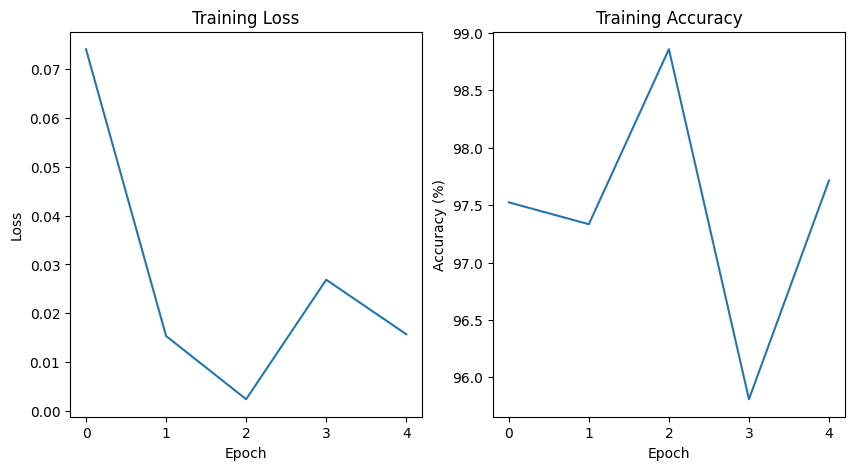

In [ ]:
# Plotting the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()


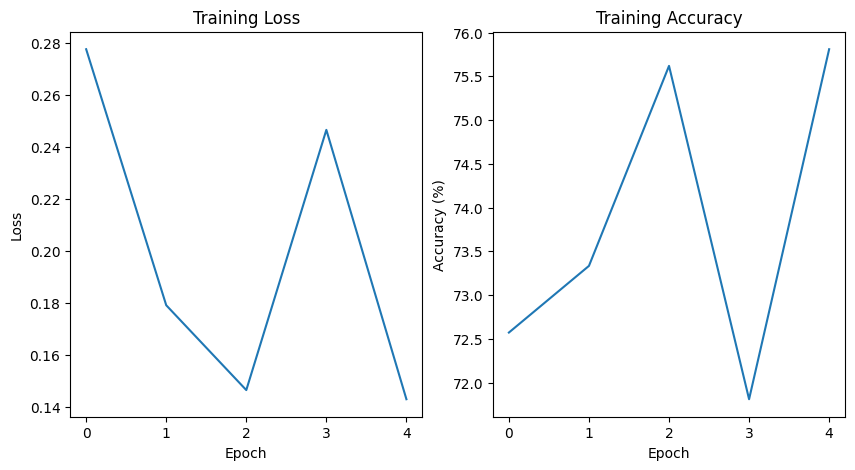

In [ ]:
# Plotting the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()

In [ ]:
# Validation loop
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    for val_batch_idx, (val_keyframes, val_optical_keyframes, val_labels) in enumerate(val_dataloader):
        val_keyframes, val_optical_keyframes, val_labels = val_keyframes.to(device), val_optical_keyframes.to(device), val_labels.to(device)

        val_outputs = model(val_keyframes, val_optical_keyframes)
        val_loss += criterion(val_outputs, val_labels).item()

        _, val_predicted = val_outputs.max(1)
        val_total += val_labels.size(0)
        val_correct += val_predicted.eq(val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_dataloader)
    print('Validation: Average loss: %.4f, Accuracy: %d %%' % (val_loss, val_accuracy))


In [ ]:
# Test loop
all_preds = []
all_labels = []
test_loss = 0.0
test_correct = 0
test_total = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for test_batch_idx, (test_keyframes, test_optical_keyframes, test_labels) in enumerate(test_dataloader):
        test_keyframes, test_optical_keyframes, test_labels = test_keyframes.to(device), test_optical_keyframes.to(device), test_labels.to(device)

        test_outputs = model(test_keyframes, test_optical_keyframes)

        # Calculate loss
        loss = criterion(test_outputs, test_labels)
        test_loss += loss.item()

        _, test_predicted = test_outputs.max(1)

        all_preds.extend(test_predicted.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()

test_loss /= len(test_dataloader)
test_accuracy = 100 * test_correct / test_total

print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 1.228, Test Accuracy: 65.40%


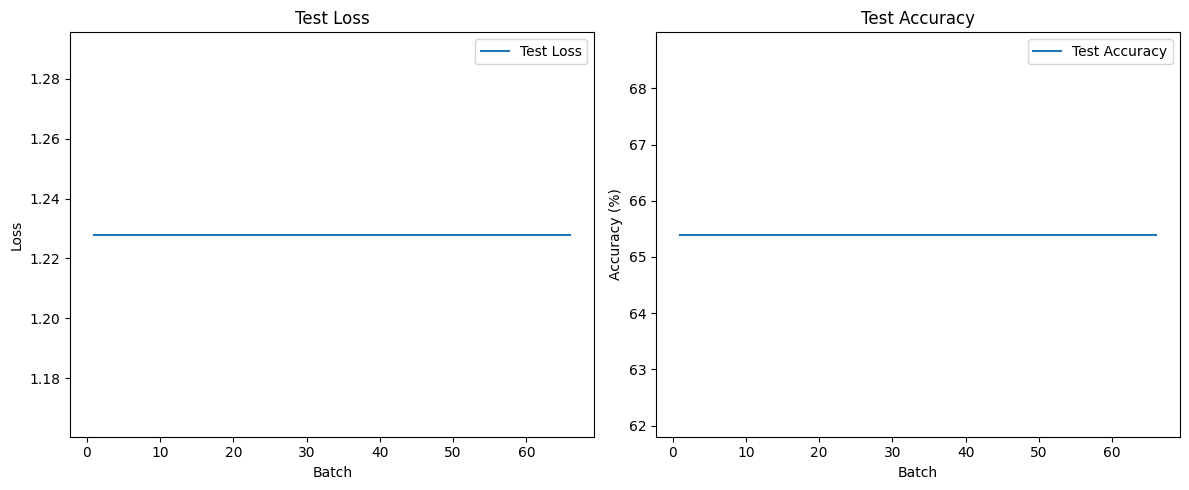

In [ ]:
# Plot test loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Test Loss
ax[0].plot(range(1, len(test_dataloader) + 1), [test_loss] * len(test_dataloader), label='Test Loss')
ax[0].set_title('Test Loss')
ax[0].set_xlabel('Batch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Test Accuracy
ax[1].plot(range(1, len(test_dataloader) + 1), [test_accuracy] * len(test_dataloader), label='Test Accuracy')
ax[1].set_title('Test Accuracy')
ax[1].set_xlabel('Batch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Test Accuracy
ax[1].plot(range(1, len(test_dataloader) + 1), [test_accuracy] * len(test_dataloader), label='Test Accuracy')
ax[1].set_title('Test Accuracy')
ax[1].set_xlabel('Batch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)


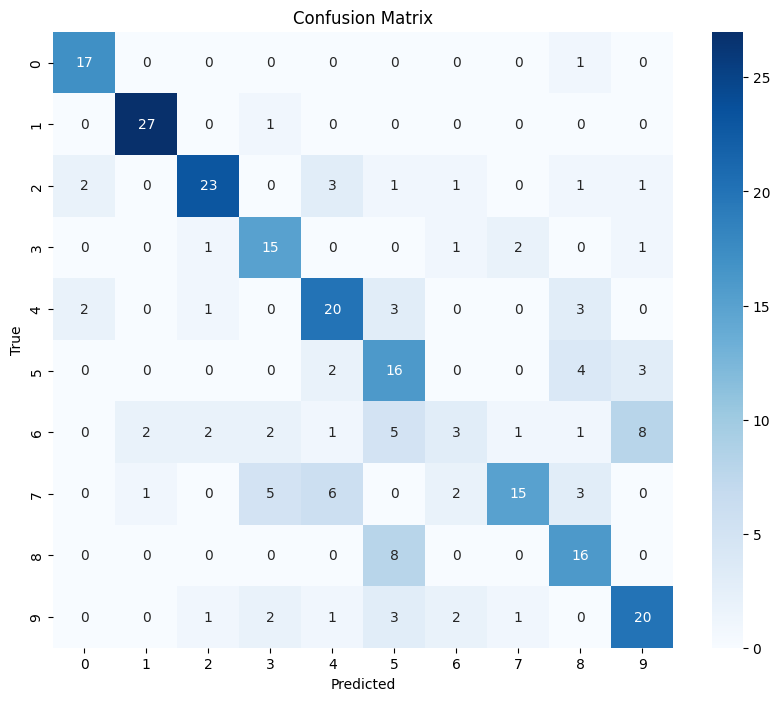

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
num_classes=10
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
PATH_MODELS= dataroot+'/Models'
torch.save(model.state_dict(), PATH_MODELS+'/northwestern_classifier54.pt')